goal: see how d1 varies based on beta vs temperature

In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import os
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 12 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")

# function that takes in a frequency and returns map using pysm
def make_map_d1(freq):
    return sky.get_emission(freq * u.GHz)
def make_map_temp(freq):
    return temp.get_emission(freq * u.GHz)
def make_map_beta(freq):
    return beta.get_emission(freq * u.GHz)
# functions that take in a map, the map_217, the cl1x1 value, and the map 217 field and outputs r80 value for BB, EE, or TT
def rbb80(map_nu2, clbb1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[3][6]
    clbb2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[3][6]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))
def ree80(map_nu2, clee1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_e = True)
    clee1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[0][6]
    clee2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[0][6]
    return clee1x2/(np.sqrt(clee1x1*clee2x2))
def rtt80(map_nu2, cltt1x1, f0_map_nu1, mask):
    # initialize spin-0 field for map2
    f0_map_nu2 = nmt.NmtField(mask, [map_nu2])
    cltt1x2 = nmt.compute_full_master(f0_map_nu1, f0_map_nu2, b)[0][6]
    cltt2x2 = nmt.compute_full_master(f0_map_nu2, f0_map_nu2, b)[0][6]
    return cltt1x2/(np.sqrt(cltt1x1*cltt2x2))
def bb_field(map_217GHz):
    return nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
def ee_field(map_217GHz):
    return nmt.NmtField(mask, map_217GHz[1:,:], purify_e = True)
def tt_field(map_217GHz):
    return nmt.NmtField(mask, [map_217GHz[0]])

# make map of constant temp (20K)
temp_20 = np.ones(3145728)*20
hp.fitsfunc.write_map("temp_20.fits",temp_20)
# make a map of constant beta (1.54)
beta_1p54 = np.ones(3145728)*1.54
hp.fitsfunc.write_map("beta_1p54.fits",beta_1p54)

In [3]:
# perform calculations using d1 model
freqs = np.arange(150,3000,150)
rbb80_vals_temp = np.ones(len(freqs))*1.
rbb80_vals_beta = np.ones(len(freqs))*1.
rbb80_vals_d1 = np.ones(len(freqs))*1.
ree80_vals_temp = np.ones(len(freqs))*1.
ree80_vals_beta = np.ones(len(freqs))*1.
ree80_vals_d1 = np.ones(len(freqs))*1.
rtt80_vals_temp = np.ones(len(freqs))*1.
rtt80_vals_beta = np.ones(len(freqs))*1.
rtt80_vals_d1 = np.ones(len(freqs))*1.

# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
os.environ["PYSM_LOCAL_DATA"] = os.getcwd()

temp = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "pysm_2/dust_beta.fits",
    map_mbb_temperature = "temp_20.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

beta = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "beta_1p54.fits",
    map_mbb_temperature = "pysm_2/dust_temp.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

# make a sky
sky = pysm3.Sky(nside=128, preset_strings=["d1"])
# make 217GHz map
map_217GHz = sky.get_emission(217 * u.GHz)
map_217GHz_temp = temp.get_emission(217 * u.GHz)
map_217GHz_beta = beta.get_emission(217 * u.GHz)
# initialize a spin-2 field for BB & EE and a spin-0 field for TT
f2_bb_d1 = bb_field(map_217GHz)
f2_bb_temp = bb_field(map_217GHz_temp)
f2_bb_beta = bb_field(map_217GHz_beta)
f2_ee_d1 = ee_field(map_217GHz)
f2_ee_temp = ee_field(map_217GHz_temp)
f2_ee_beta = ee_field(map_217GHz_beta)
f0_tt_d1 = tt_field(map_217GHz)
f0_tt_temp = tt_field(map_217GHz_temp)
f0_tt_beta = tt_field(map_217GHz_beta)
# compute their cl80 values
clbb1x1_d1 = nmt.compute_full_master(f2_bb_d1, f2_bb_d1, b)[3][6]
clbb1x1_temp = nmt.compute_full_master(f2_bb_temp, f2_bb_temp, b)[3][6]
clbb1x1_beta = nmt.compute_full_master(f2_bb_beta, f2_bb_beta, b)[3][6]
clee1x1_d1 = nmt.compute_full_master(f2_ee_d1, f2_ee_d1, b)[0][6]
clee1x1_temp = nmt.compute_full_master(f2_ee_temp, f2_ee_temp, b)[0][6]
clee1x1_beta = nmt.compute_full_master(f2_ee_beta, f2_ee_beta, b)[0][6]
cltt1x1_d1 = nmt.compute_full_master(f0_tt_d1, f0_tt_d1, b)[0][6]
cltt1x1_temp = nmt.compute_full_master(f0_tt_temp, f0_tt_temp, b)[0][6]
cltt1x1_beta = nmt.compute_full_master(f0_tt_beta, f0_tt_beta, b)[0][6]
# compute Rl[80] for every 150GHz from 150GHz to 3THz
for i, freq in enumerate(freqs):
    map_freq_d1 = make_map_d1(freq)
    map_freq_temp = make_map_temp(freq)
    map_freq_beta = make_map_beta(freq)
    rbb80_vals_d1[i] = (1 - rbb80(map_freq_d1[1:,:], clbb1x1_d1, f2_bb_d1, mask))
    rbb80_vals_temp[i] = (1 - rbb80(map_freq_temp[1:,:], clbb1x1_temp, f2_bb_temp, mask))
    rbb80_vals_beta[i] = (1 - rbb80(map_freq_beta[1:,:], clbb1x1_beta, f2_bb_beta, mask))
    ree80_vals_d1[i] = (1 - ree80(map_freq_d1[1:,:], clee1x1_d1, f2_ee_d1, mask))
    ree80_vals_temp[i] = (1 - ree80(map_freq_temp[1:,:], clee1x1_temp, f2_ee_temp, mask))
    ree80_vals_beta[i] = (1 - ree80(map_freq_beta[1:,:], clee1x1_beta, f2_ee_beta, mask))
    rtt80_vals_d1[i] = (1 - rtt80(map_freq_d1[0,:], cltt1x1_d1, f0_tt_d1, mask))
    rtt80_vals_temp[i] = (1 - rtt80(map_freq_temp[0,:], cltt1x1_temp, f0_tt_temp, mask))
    rtt80_vals_beta[i] = (1 - rtt80(map_freq_beta[0,:], cltt1x1_beta, f0_tt_beta, mask))

In [4]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

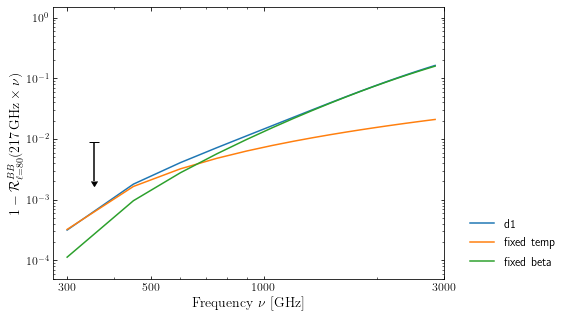

In [5]:
# plot all d1, temp, and beta for BB
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], rbb80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], rbb80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], rbb80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('bb_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

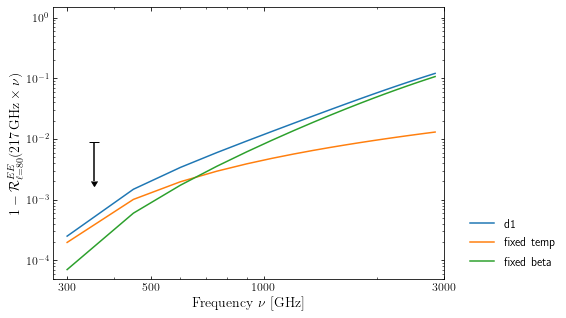

In [6]:
# plot all d1, temp, and beta for EE
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{EE}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], ree80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], ree80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], ree80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('ee_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

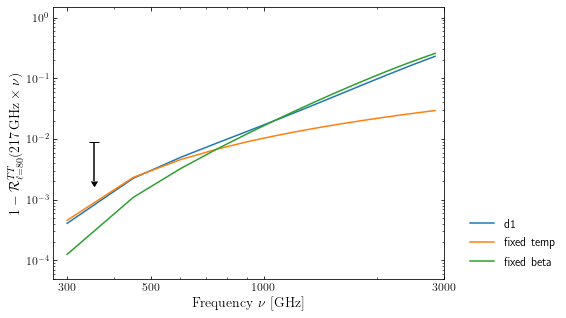

In [7]:
# plot all d1, temp, and beta for TT
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{TT}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], rtt80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], rtt80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], rtt80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('tt_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')